<a href="https://colab.research.google.com/github/vanessaaleung/discount-optimization/blob/master/Product_Discount_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Edited by: Vanessa Liang

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math
import datetime
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from sklearn import preprocessing
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/ormarketing/b2b/master/data.csv')
df.head()

,ID,Close Date,Created Date,New Logo,Type,Stage,Billing Plan,ACV,Discount Amount,Amount,Net Amount
0,1,5/26/17,5/4/17,1,Direct - Cloud Product,Closed Lost,3 Years,431370,,225000,225000
1,2,12/29/16,11/29/16,1,Partner - OnPremise Product,Closed Won - Paid,3 Years,22050,80850,147000,66150
2,3,12/29/16,12/9/16,1,Partner - Cloud Product,Closed Won - Paid,3 Years,32750,43200,96000,52800
3,4,9/9/16,4/20/16,1,Direct - Cloud Product,Closed Won - Paid,4 Years,36694,44800,128000,83200
4,5,9/22/16,9/1/16,1,Partner - OnPremise Product,Closed Won - Paid,3 Years,18700,9900,66000,56100


In [ ]:
# simplify stage to lost/win
df['Stage']=np.where(df['Stage'] =='Closed Lost', 'Lost', df['Stage'])
df['Stage']=np.where(df['Stage'] =='Closed Won - Paid', 'Won', df['Stage'])
df['Stage']=np.where(df['Stage'] =='Closed Won - Not Paid', 'Won', df['Stage'])
df['Stage']=np.where(df['Stage'] =='Closed - Lost', 'Lost', df['Stage'])
df['Stage']=np.where(df['Stage'] =='Closed Lost - Not Renewing', 'Lost', df['Stage'])

In [ ]:
# create dummies for type
df['Partner cloud']=np.where(df['Type'] =='Partner - Cloud Product', 1.0,0.0)
df['Partner prem']=np.where(df['Type'] =='Partner - OnPremise Product', 1.0, 0.0)
df['Direct cloud']=np.where(df['Type'] =='Direct - Cloud Product', 1.0,0.0)
df['Direct prem']=np.where(df['Type'] =='Direct - OnPremise Product', 1.0, 0.0)
df['amount']=pd.to_numeric(df[' Amount '], errors='coerce')
df['net amount']=pd.to_numeric(df[' Net Amount '],errors='coerce')
df['discount'] = df['amount'] - df['net amount']
df['depth'] = df['discount']/df['amount']
df = df.drop([' ACV ',' Discount Amount ',' Amount ', ' Net Amount ', 'Billing Plan'],axis=1)  # Billing-plan is a variable we didn’t use
df.head()

,ID,Close Date,Created Date,New Logo,Type,Stage,Partner cloud,Partner prem,Direct cloud,Direct prem,amount,net amount,discount,depth
0,1,5/26/17,5/4/17,1,Direct - Cloud Product,Lost,0.0,0.0,1.0,0.0,225000.0,225000.0,0.0,0.00
1,2,12/29/16,11/29/16,1,Partner - OnPremise Product,Won,0.0,1.0,0.0,0.0,147000.0,66150.0,80850.0,0.55
2,3,12/29/16,12/9/16,1,Partner - Cloud Product,Won,1.0,0.0,0.0,0.0,96000.0,52800.0,43200.0,0.45
3,4,9/9/16,4/20/16,1,Direct - Cloud Product,Won,0.0,0.0,1.0,0.0,128000.0,83200.0,44800.0,0.35
4,5,9/22/16,9/1/16,1,Partner - OnPremise Product,Won,0.0,1.0,0.0,0.0,66000.0,56100.0,9900.0,0.15


**There is probably an “end-of-the-quarter” effect, i.e., as the end of the quarter approaches, salespeople might give deeper discount. You might want to test this hypothesis.**

```
From the graph below, we can't conclude there's a "end-of-the-quarter" effect.
```

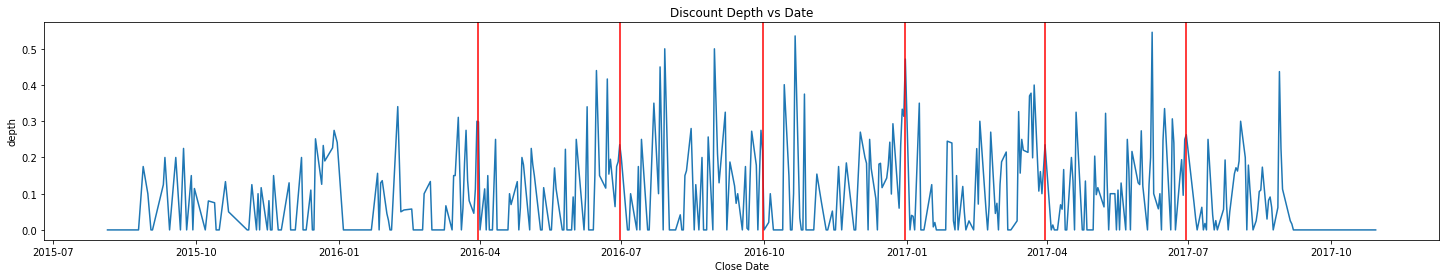

In [ ]:
# plot close date vs depth
df['Close Date'] = pd.to_datetime(df['Close Date'])

plt.figure(figsize=(25,4))
sns.lineplot(x='Close Date', y='depth', data = df, ci=None).set_title("Discount Depth vs Date")

# plot the quarter end date
plt.axvline(datetime.datetime.strptime('2016-03-31', '%Y-%m-%d'), color='red')
plt.axvline(datetime.datetime.strptime('2016-06-30', '%Y-%m-%d'), color='red')
plt.axvline(datetime.datetime.strptime('2016-09-30', '%Y-%m-%d'), color='red')
plt.axvline(datetime.datetime.strptime('2016-12-31', '%Y-%m-%d'), color='red')
plt.axvline(datetime.datetime.strptime('2017-03-31', '%Y-%m-%d'), color='red')
plt.axvline(datetime.datetime.strptime('2017-06-30', '%Y-%m-%d'), color='red')

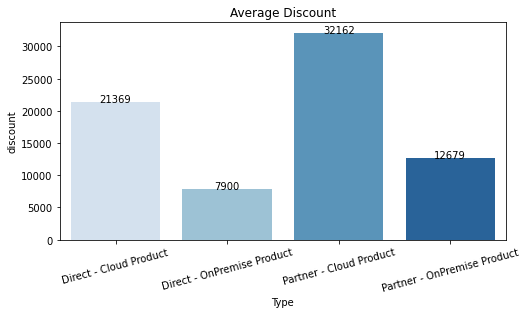

In [ ]:
# plot average discount for each product
plt.figure(figsize=(8,4))
avg_discount = pd.DataFrame(df.groupby('Type', as_index=False)['discount'].mean())
fig = sns.barplot('Type', 'discount', data = avg_discount, palette='Blues')
fig.set_title("Average Discount")
fig.set_xticklabels(fig.get_xticklabels(), rotation=15)
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), ha='center')

**1. Split the data in two samples, i.e., the estimation sample (ID 1 to 1200) and the hold- out sample (ID 1201 to 1505).**

In [ ]:
estimation_sample = df[(df["ID"] >= 1) & (df["ID"] <= 1200)]
hold_out_sample = df[(df["ID"] >= 1201) & (df["ID"] <= 1505)]
estimation_sample = estimation_sample.drop(['ID'],axis=1)
hold_out_sample = hold_out_sample.drop(['ID'],axis=1).reset_index()
print(len(estimation_sample), len(hold_out_sample))

1200 305


**2. Using the estimation sample, estimate one or several logit models (or something else).**

In [ ]:
estimation_sample['y'] = np.where(estimation_sample['Stage'] =='Won', 1.0,0.0)
y = estimation_sample['y']
x = estimation_sample[['discount','amount','New Logo', 'Partner cloud', 'Partner prem', 'Direct cloud','Direct prem']]
model = sm.Logit(y, x, missing='drop')
model.fit
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.445041
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1151
Model:                          Logit   Df Residuals:                     1144
Method:                           MLE   Df Model:                            6
Date:                Thu, 04 Jun 2020   Pseudo R-squ.:                  0.3318
Time:                        00:27:01   Log-Likelihood:                -512.24
converged:                       True   LL-Null:                       -766.56
Covariance Type:            nonrobust   LLR p-value:                1.160e-106
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
discount       5.506e-05   6.59e-06      8.352      0.000    4.21e-05     6.8e-05
amount        -1.804

In [ ]:
# optimization
x = hold_out_sample[['discount','amount','New Logo', 'Partner cloud', 'Partner prem', 'Direct cloud','Direct prem']]

ID = 0
ID_max = len(hold_out_sample)
optimized_discount = np.empty([ID_max, ])

def revenue_optimal_discount(d):
  numerator = np.exp(utility + discount_coef * np.sqrt(d ** 2))
  denominator = (1 + np.exp(utility + discount_coef * np.sqrt(d ** 2)))
  return - numerator / denominator * (amount_of_id - np.sqrt(d ** 2))

while ID <= ID_max - 1:
  utility = np.matmul(x.iloc[ID, 1:7], result.params[1:7]) 
  discount_coef = result.params[0]
  amount_of_id = x.iloc[ID, 1]
  sol3 = minimize_scalar(revenue_optimal_discount)
  optimized_discount[ID] = sol3.x
  ID += 1
print("Mean of Optimized discount: ", round(np.mean(optimized_discount), 0))
print("Mean of Actual discount: ", round(np.mean(hold_out_sample['discount']), 0))

Mean of Optimized discount:  13557.0
Mean of Actual discount:  12685.0


In [ ]:
# calculate average optimal discount
hold_out_sample['optimal discount'] = np.sqrt(optimized_discount ** 2)
round(hold_out_sample.groupby('Type').mean(),2)

,index,New Logo,Partner cloud,Partner prem,Direct cloud,Direct prem,amount,net amount,discount,depth,optimal discount
Type,,,,,,,,,,,
Direct - Cloud Product,1315.00,0.71,0.0,0.0,1.0,0.0,64117.65,51645.88,12471.76,0.13,22118.00
Direct - OnPremise Product,1359.00,0.32,0.0,0.0,0.0,1.0,33464.41,30527.40,2937.01,0.04,8453.22
Partner - Cloud Product,1317.28,0.83,1.0,0.0,0.0,0.0,141035.94,88406.72,52629.22,0.22,32126.23
Partner - OnPremise Product,1359.85,0.36,0.0,1.0,0.0,0.0,52695.51,42431.60,10492.98,0.09,11950.59


**Your performance metrics are (I’ll use these two metrics to compare groups):**

**a. Expected revenue improvement over un-optimized discounts (take the actual discounts in the data-set) for leads in the hold-out sample**

In [ ]:
# calculate optimized revenue
x = hold_out_sample[['discount','amount','New Logo','Partner cloud','Partner prem','Direct cloud','Direct prem']]

ID = 0
ID_max = len(hold_out_sample)
optimized_revenue = np.empty([ID_max,])

while ID <= ID_max-1:
  col_idx = 0
  utility = 0
  while col_idx < len(x.columns):
    utility += x.iloc[ID][col_idx] * result.params[col_idx]
    col_idx += 1
  proba = np.exp(utility)/(1 + np.exp(utility))
  optimized_revenue[ID] = proba * (x['amount'][ID] - x['discount'][ID])
  ID += 1
optimized_revenue = np.nan_to_num(optimized_revenue)

In [ ]:
hold_out_sample['Revenue'] = np.where(hold_out_sample['Stage'] =='Won', hold_out_sample['net amount'] ,0.0)
print("Optimized expected revenue / Actual revenues = ", round(np.sum(optimized_revenue)/np.sum(hold_out_sample['Revenue']),2))

Optimized expected revenue / Actual revenues =  1.2


In [ ]:
hold_out_sample['Optimized Revenue'] = optimized_revenue
hold_out_sample['Improved Revenue'] = hold_out_sample['Optimized Revenue'] - hold_out_sample['Revenue']
hold_out_sample_copy = hold_out_sample[['Type', 'discount','optimal discount','Revenue','Optimized Revenue', 'Improved Revenue']]
hold_out_group = round(hold_out_sample_copy.groupby('Type').mean(), 2)
hold_out_group['Improved Revenue %'] = round(hold_out_group['Improved Revenue']/hold_out_group['Revenue'], 2)
hold_out_group

,discount,optimal discount,Revenue,Optimized Revenue,Improved Revenue,Improved Revenue %
Type,,,,,,
Direct - Cloud Product,12471.76,22118.00,9029.41,20208.02,11178.61,1.24
Direct - OnPremise Product,2937.01,8453.22,4851.02,6530.49,1679.47,0.35
Partner - Cloud Product,52629.22,32126.23,58460.92,59098.55,637.63,0.01
Partner - OnPremise Product,10492.98,11950.59,15357.20,19499.54,4287.85,0.28


**b. Expected revenue improvement over optimized discounts (based on your estimation results, optimize discounts offered to leads in the hold-out sample).**

In [ ]:
# calculate optimized revenue
x = hold_out_sample[['optimal discount','amount','New Logo','Partner cloud','Partner prem','Direct cloud','Direct prem']]

ID = 0
ID_max = len(hold_out_sample)
optimized_revenue = np.empty([ID_max,])

while ID <= ID_max-1:
  col_idx = 0
  utility = 0
  while col_idx < len(x.columns):
    utility = utility + x.iloc[ID][col_idx] * result.params[col_idx]
    col_idx += 1
  proba = np.exp(utility)/(1 + np.exp(utility))
  optimized_revenue[ID] = proba * (x['amount'][ID] - optimized_discount[ID])
  ID += 1
optimized_revenue = np.nan_to_num(optimized_revenue)

In [ ]:
hold_out_sample['Revenue'] = np.where(hold_out_sample['Stage'] =='Won', hold_out_sample['net amount'] ,0.0)
print("Optimized expected revenue / Actual revenues = ", round(np.sum(optimized_revenue)/np.sum(hold_out_sample['Revenue']),2))

Optimized expected revenue / Actual revenues =  1.61


In [ ]:
hold_out_sample['Optimized Revenue'] = optimized_revenue
hold_out_sample['Improved Revenue'] = hold_out_sample['Optimized Revenue'] - hold_out_sample['Revenue']
hold_out_sample_copy = hold_out_sample[['Type','discount','optimal discount','Revenue','Optimized Revenue', 'Improved Revenue']]
hold_out_group = round(hold_out_sample_copy.groupby('Type').mean(), 2)
hold_out_group['Improved Revenue %'] = round(hold_out_group['Improved Revenue']/hold_out_group['Revenue'], 2)
hold_out_group

,discount,optimal discount,Revenue,Optimized Revenue,Improved Revenue,Improved Revenue %
Type,,,,,,
Direct - Cloud Product,12471.76,22118.00,9029.41,24332.93,15303.51,1.69
Direct - OnPremise Product,2937.01,8453.22,4851.02,8067.76,3216.75,0.66
Partner - Cloud Product,52629.22,32126.23,58460.92,90747.89,32286.97,0.55
Partner - OnPremise Product,10492.98,11950.59,15357.20,24114.16,8841.47,0.58
